In [122]:
"""
File: survey2024.ipynb
Author: Rich Sharples
Date: October-2024
Description: 
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py

py.init_notebook_mode(connected=True)

from collections import Counter

import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import csv

import math

# ignore category data less than this threshold
THRESHOLD = 4 

#
# Function : double_bar_chart
#
def double_bar_chart(qnum, qtext, ds1_name, data_series_1, ds2_name, data_series_2):

    ct = f"{qnum} : {qtext} (n={data_series_1.sum()+data_series_2.sum()})"
    
    # Create the figure with stacked bars
    fig = go.Figure(data=[
        go.Bar(name=ds1_name, x=data_series_1.index, y=data_series_1.values),
        go.Bar(name=ds2_name, x=data_series_2.index, y=data_series_2.values)
    ])

    # Update the layout to stack the bars
    fig.update_layout(
        barmode='stack',
        title=ct,
        plot_bgcolor="#FFFFFF",
        showlegend=True,
        xaxis={'categoryorder':'total descending'})

    fig.update_layout(width=900, height=500, bargap=0.05)
    
    # Show the plot
    fig.show()

    #Anything interesting in Other ?

    qother=qnum+"Other"

    others=[]
    if qother in raw_df.columns:
        for v in raw_df[qother]:
           others.append (v)

        # Create a Counter object to count the frequency of each string
        frequency_counts = Counter(others)

        # Convert the Counter to a list of tuples (unique string, count)
        unique_entries_with_counts = list(frequency_counts.items())

        # Sort by frequency (descending)
        sorted_by_frequency = sorted(unique_entries_with_counts, key=lambda x: x[1], reverse=True)

        listofothers=[]
    
        for x in sorted_by_frequency:
            if (not (str(x[0]) == "nan"))   & (x[1] > THRESHOLD):
                listofothers.append( (f"{x[0]}({x[1]})"))
  
        print(f"Other answers with frequency greater than {THRESHOLD} : {" ".join(listofothers)}")
  


In [123]:
DATA_FILENAME = "raw-data-102624.xlsx"
QUESTION_FILENAME = "questions.csv"

#read questions from separate file
questions = { }
with open(QUESTION_FILENAME) as f:
    reader = csv.reader(f, skipinitialspace=True)
    questions = dict(reader)

raw_df = pd.read_excel(DATA_FILENAME, engine="openpyxl")

#drop columns we don't care about
raw_df.drop (columns=['#', "Response Type", "Start Date (UTC)", "Stage Date (UTC)", "Submit Date (UTC)", "Network ID", "Tags"], inplace=True)

#rename columns to make things easier
raw_df.rename( columns=
              {
                questions['Q1'] : 'Q1',
                questions['Q2'] : 'Q2',
                'Other' : 'Q2Other',
                'How many staff does your organization employ?': 'Q3', 
                'What is your organization’s annual revenue?' : 'Q4',
                'How many years has your organization been using container technology?' : 'Q5',
                'How many years has your organization been using CI/CD ?' : 'Q6',
                'How many years has your organization been using GitOps?' : 'Q7',
                'What is your current role?' : 'Q8',
                'Other.1' : 'Q8Other',
                questions['Q9'] : 'Q9',
                questions['Q10'] : 'Q10',
                questions['Q11'] : 'Q11',
                questions['Q12.A1'] : 'Q12.A1',
                questions['Q12.A2'] : 'Q12.A2',
                questions['Q12.A3'] : 'Q12.A3',
                questions['Q12.A4'] : 'Q12.A4',
                questions['Q12.A5'] : 'Q12.A5',
                questions['Q12.A6'] : 'Q12.A6',
                questions['Q12.A7'] : 'Q12.A7',
                questions['Q12.A8'] : 'Q12.A8',              
                questions['Q12.Other'] : 'Q12.Other',
                questions['Q13.A1'] : 'Q13.A1',
                questions['Q13.A2'] : 'Q13.A2',
                questions['Q13.A3'] : 'Q13.A3',
                questions['Q13.A4'] : 'Q13.A4',
                questions['Q13.A5'] : 'Q13.A5',
                questions['Q13.A6'] : 'Q13.A6',
                questions['Q13.A7'] : 'Q13.A7',           
                questions['Q13.Other'] : 'Q13.Other',   
                questions['Q14.A1'] : 'Q14.A1',
                questions['Q14.A2'] : 'Q14.A2',
                questions['Q14.A3'] : 'Q14.A3',
                questions['Q14.A4'] : 'Q14.A4',          
                questions['Q14.Other'] : 'Q14.Other', 
                questions['Q16'] : 'Q16',
                questions['Q17'] : 'Q17'
              },
              inplace=True)

# data cleaning

# "$" signs in Q4 break plotly so replace with "USD"
tempdf = raw_df["Q4"] \
    .str.replace('US$', 'USD ', regex=False) \
    .str.replace('million', 'MM', regex=False) \
    .str.replace('billion', 'BB', regex=False) \
    .str.replace('$', 'USD ', regex=False)

raw_df["Q4"] = tempdf


# shorten country names in Q10

tempdf = raw_df["Q10"] \
    .str.replace('United Kingdom', 'UK', regex=False) \
    .str.replace('New Zealand', 'NZ', regex=False) \
    .str.replace('Czech Republic', 'CZ', regex=False) \
    .str.replace('United States', 'USA', regex=False)

raw_df["Q10"] = tempdf

# shorten Q11 answers
tempdf = raw_df["Q11"] \
    .str.replace('Developing and packaging custom developed software', 'custom s/w', regex=False) \
    .str.replace('Installing containerized open source software', 'OSS', regex=False) \
    .str.replace('Installing containerized commercial software', 'commercial s/w', regex=False) \

raw_df["Q11"] = tempdf

# split into two data sets depending on Home or Work usage

CHOME = "At home"
CWORK = "At work"

home_df = raw_df.query("`Q1` == @CHOME").copy()
work_df = raw_df.query("`Q1` == @CWORK").copy()



/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [124]:
# Q1 - home or work ?
#

temp_series = raw_df['Q1'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series)))


trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Home vs Work'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="home-work")



In [125]:
# 
# Q12.A1 - Q12.A8
# Answers are in columns Q12.A1 - Q12.A8 
# conactenate the list of value counts and pass them to the standard chart function
#

wq = pd.concat([work_df["Q12.A1"].value_counts(),\
                work_df["Q12.A3"].value_counts(),\
                work_df["Q12.A4"].value_counts(),\
                work_df["Q12.A5"].value_counts(),\
                work_df["Q12.A6"].value_counts(),\
                work_df["Q12.A7"].value_counts(),\
                work_df["Q12.A8"].value_counts()])

hq = pd.concat([home_df["Q12.A1"].value_counts(),\
                home_df["Q12.A2"].value_counts(),\
                home_df["Q12.A3"].value_counts(),\
                home_df["Q12.A4"].value_counts(),\
                home_df["Q12.A5"].value_counts(),\
                home_df["Q12.A6"].value_counts(),\
                home_df["Q12.A7"].value_counts(),\
                home_df["Q12.A8"].value_counts()])

value = questions[key]

double_bar_chart(
    "Q12.A1",
    questions["#Q12"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


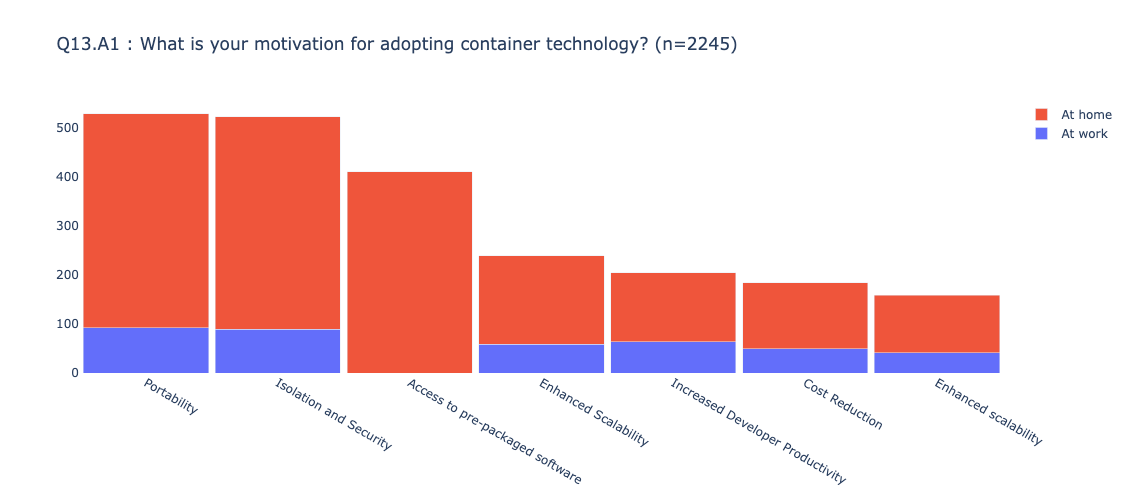

In [126]:
# 
# Q13.A1 - Q13.A7
#

wq = pd.concat([work_df["Q13.A1"].value_counts(),\
                work_df["Q13.A3"].value_counts(),\
                work_df["Q13.A4"].value_counts(),\
                work_df["Q13.A5"].value_counts(),\
                work_df["Q13.A6"].value_counts(),\
                work_df["Q13.A7"].value_counts(),\
                work_df["Q13.Other"].value_counts()])

hq = pd.concat([home_df["Q13.A1"].value_counts(),\
                home_df["Q13.A2"].value_counts(),\
                home_df["Q13.A3"].value_counts(),\
                home_df["Q13.A4"].value_counts(),\
                home_df["Q13.A5"].value_counts(),\
                home_df["Q13.A6"].value_counts(),\
                home_df["Q13.A7"].value_counts(),\
                home_df["Q13.Other"].value_counts()])

value = questions[key]

double_bar_chart(
    "Q13.A1",
    questions["#Q13"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


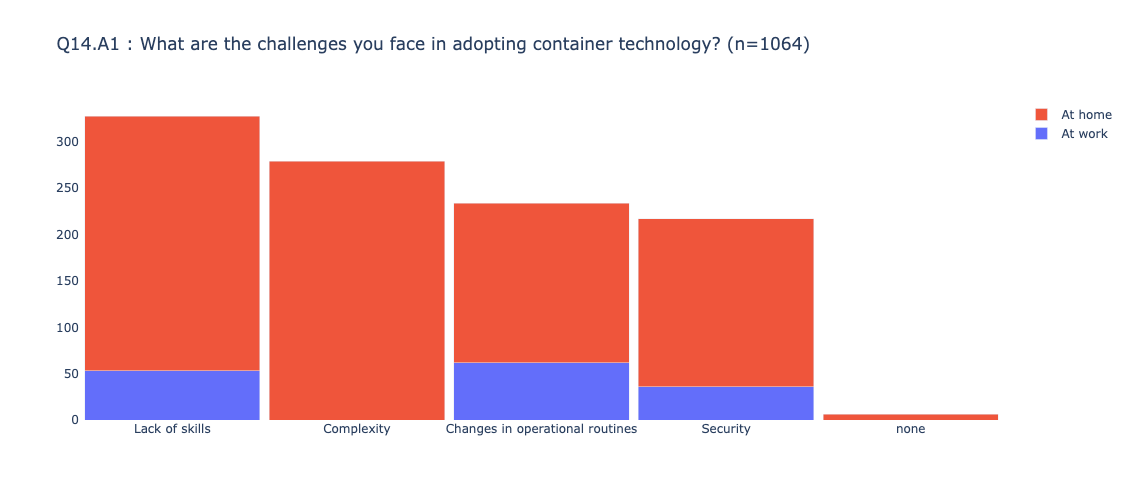

In [127]:
# 
# Q14.A1 - Q14.A4
#

wq = pd.concat([work_df["Q14.A1"].value_counts(),\
                work_df["Q14.A3"].value_counts(),\
                work_df["Q14.A4"].value_counts(),\
                work_df["Q14.Other"].value_counts()])

hq = pd.concat([home_df["Q14.A1"].value_counts(),\
                home_df["Q14.A2"].value_counts(),\
                home_df["Q14.A3"].value_counts(),\
                home_df["Q14.A4"].value_counts(),\
                home_df["Q14.Other"].value_counts()])

value = questions[key]

double_bar_chart(
    "Q14.A1",
    questions["#Q14"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


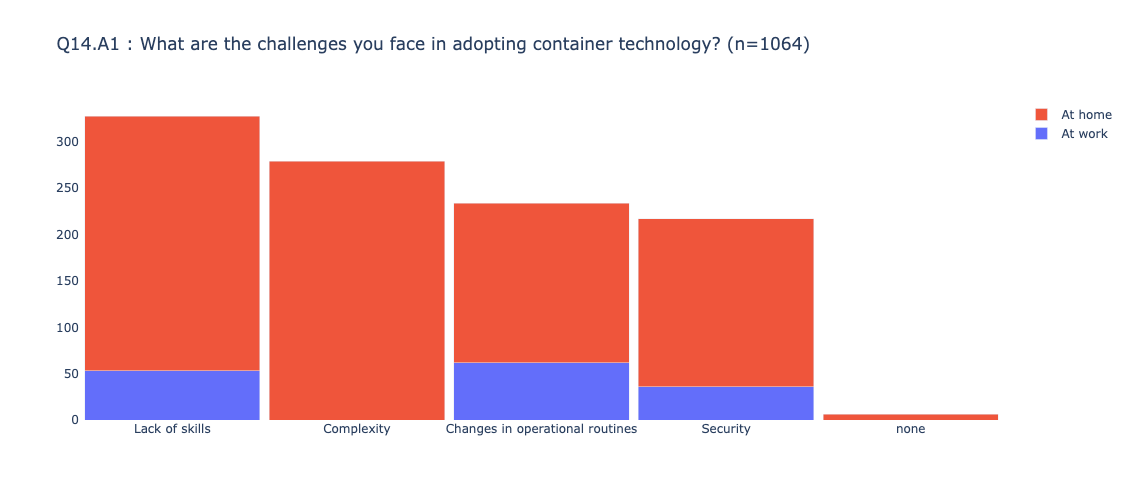

In [127]:
# 
# Q15.A1 - Q14.A4
#

wq = pd.concat([work_df["Q14.A1"].value_counts(),\
                work_df["Q14.A3"].value_counts(),\
                work_df["Q14.A4"].value_counts(),\
                work_df["Q14.Other"].value_counts()])

hq = pd.concat([home_df["Q14.A1"].value_counts(),\
                home_df["Q14.A2"].value_counts(),\
                home_df["Q14.A3"].value_counts(),\
                home_df["Q14.A4"].value_counts(),\
                home_df["Q14.Other"].value_counts()])

value = questions[key]

double_bar_chart(
    "Q14.A1",
    questions["#Q14"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])
